In [1]:
import os
import time
import datetime
import itertools
import cartopy
import matplotlib

import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gp

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

from matplotlib.lines import Line2D
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from descartes import PolygonPatch
from itertools import combinations
from collections import OrderedDict 

In [2]:
# kaweah shapefile
kaweah = gp.read_file("../shape/kaweah/c2vsim_sub_18.shp")
k_area_km2 = float(kaweah.to_crs({'init': 'epsg:32611'}).area * 1e-6)
kaweah.crs = {"init":"epsg:4326"}

# butte shapefile
kaweah = gp.read_file("../shape/butte/c2vsim_subregion5.shp")
k_area_km2 = float(kaweah.to_crs({'init': 'epsg:32611'}).area * 1e-6)
kaweah.crs = {"init":"epsg:4326"}

# flowlines
flowlines = gp.read_file("../shape/NHD_Major_Rivers_and_Creeks.shp")

# Rivers
rivers = gp.read_file("../shape/streams.shp")

# Reservoirs
k_reservoirs = gp.read_file("../shape/kaweah/res_within.shp")
b_reservoirs = gp.read_file("../shape/butte/res_within.shp")

# Inflow
k_inflow = gp.read_file("../shape/kaweah/inflow.shp")
b_inflow = gp.read_file("../shape/butte/inflow.shp")

# Outflow 
b_outflow = gp.read_file("../shape/butte/outflow.shp")

/Users/aakashahamed/anaconda3/envs/rsenv/lib/python3.8/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [3]:
t = gp.read_file("../shape/casgem_wells.shp")
t.crs

In [4]:
gdf = gp.read_file("../shape/NHD_Major_Rivers_and_Creeks.shp")

In [5]:
keeps = [x for x in gdf['gnis_name'] if "Feather" in x]
gdf[gdf['gnis_name'].isin(keeps)].to_file("../shape/feather_riv.shp")

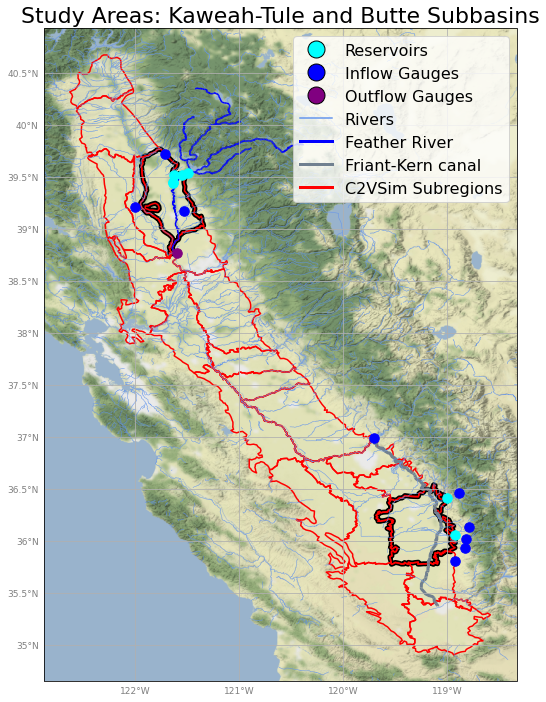

In [6]:
# Read datasets

# flowlines = ShapelyFeature(Reader("../shape/C2VSimFG_StreamReaches.shp").geometries(),
#                         ccrs.PlateCarree(), edgecolor='blue', facecolor = 'none', linewidth = 2)

butte = ShapelyFeature(Reader("../shape/butte/c2vsim_subregion5.shp").geometries(),
                        ccrs.PlateCarree(), edgecolor='black', facecolor = 'none', linewidth = 5)

kaweah = ShapelyFeature(Reader("../shape/kaweah/c2vsim_sub_18.shp").geometries(),
                        ccrs.PlateCarree(), edgecolor='black', facecolor = 'none', linewidth = 5)

subregions = ShapelyFeature(Reader("../shape/C2VSimFG_Subregions.shp").geometries(),
                        ccrs.PlateCarree(), edgecolor='red', facecolor = 'none', linewidth = 1.5)

cv = ShapelyFeature(Reader("../shape/cv.shp").geometries(),
                        ccrs.PlateCarree(), edgecolor='green', facecolor = 'none', linewidth = 2)

streams = ShapelyFeature(Reader("../shape/NHD_Major_Rivers_and_Creeks.shp").geometries(),
                        ccrs.PlateCarree(), edgecolor='cornflowerblue', facecolor = 'none', linewidth = 0.5)

fkc = ShapelyFeature(Reader("../shape/fkc_fin.shp").geometries(),
                        ccrs.PlateCarree(), edgecolor='slategray', facecolor = 'none', linewidth = 3)

feather_riv = ShapelyFeature(Reader("../shape/feather_riv.shp").geometries(),
                        ccrs.PlateCarree(), edgecolor='blue', facecolor = 'none', linewidth = 1.5)


# Setup the figure
shapefile = "../shape/cv.shp"
plt.figure(figsize = (20,12))
ax = plt.axes(projection=ccrs.PlateCarree())

# Get some 
imextent = gp.read_file(shapefile).to_crs(4326).bounds
crs= gp.read_file(shapefile).to_crs(4326)

lllon, lllat = imextent.minx.values[0], imextent.miny.values[0]
urlon, urlat = imextent.maxx.values[0], imextent.maxy.values[0]

# Create a Stamen Terrain instance.
stamen_terrain = cimgt.Stamen('terrain-background')

# Create a GeoAxes in the tile's projection.
gl = ax.gridlines(draw_labels=True)
gl.top_labels= False
gl.right_labels = False

gl.xlocator = mticker.FixedLocator(np.linspace(-180,180,361))
gl.ylocator = mticker.FixedLocator(np.linspace(0,90,181))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 9, 'color': 'gray'}
gl.ylabel_style = {'size': 9, 'color': 'gray'}

# Limit the extent of the map to a small longitude/latitude range.
ax.set_extent([lllon-.25, urlon+.25, lllat-.25, urlat+.25])

# Add the Stamen data at zoom level 8.
ax.add_image(stamen_terrain, 8)

# Add wells
wells = list(cartopy.io.shapereader.Reader("../shape/wells_in_cv.shp").geometries())
# ax.scatter([point.x for point in wells],
#            [point.y for point in wells],
#            transform=ccrs.PlateCarree(), color = 'orange', s = 0.6)

# Add shapefiles (order matters)
# ax.add_feature(cv)
# ax.add_feature(flowlines)

ax.add_feature(kaweah)
ax.add_feature(butte)
ax.add_feature(subregions)
ax.add_feature(fkc)
ax.add_feature(streams)
ax.add_feature(feather_riv)

# Add reservoirs
reservoirs_k = list(cartopy.io.shapereader.Reader("../shape/kaweah/res_within.shp").geometries())
ax.scatter([point.x for point in reservoirs_k],
           [point.y for point in reservoirs_k],
           transform=ccrs.PlateCarree(), color = 'cyan', s = 90, zorder = 1000)

reservoirs_b = list(cartopy.io.shapereader.Reader("../shape/butte/res_within.shp").geometries())
ax.scatter([point.x for point in reservoirs_b],
           [point.y for point in reservoirs_b],
           transform=ccrs.PlateCarree(), color = 'cyan', s = 90, zorder = 1000)

# Add Inflow/outflow
inflow_b = list(cartopy.io.shapereader.Reader("../shape/kaweah/inflow.shp").geometries())
ax.scatter([point.x for point in inflow_b],
           [point.y for point in inflow_b],
           transform=ccrs.PlateCarree(), color = 'blue', s = 90, zorder = 1000)

inflow_k = list(cartopy.io.shapereader.Reader("../shape/butte/inflow.shp").geometries())
ax.scatter([point.x for point in inflow_k],
           [point.y for point in inflow_k],
           transform=ccrs.PlateCarree(), color = 'blue', s = 90, zorder = 1000)

outflow_b = list(cartopy.io.shapereader.Reader("../shape/butte/outflow.shp").geometries())
ax.scatter([point.x for point in outflow_b],
           [point.y for point in outflow_b],
           transform=ccrs.PlateCarree(), color = 'purple', s = 90, zorder = 1000)

# Setup legend
handles, labels = plt.gca().get_legend_handles_labels()

# Add legend entries
res_line = Line2D(range(0), range(0), label = 'Reservoirs', color="none", marker='o', markerfacecolor="cyan", markersize = 17)
in_gauges_line = Line2D(range(0), range(0), label = 'Inflow Gauges', color="none", marker='o', markerfacecolor="blue", markersize = 17)
out_gauges_line = Line2D(range(0), range(0), label = 'Outflow Gauges', color="none", marker='o', markerfacecolor="purple", markersize = 17)
well_line = Line2D(range(0), range(0), label = 'Groundwater Wells', color="none", marker='o', markerfacecolor="orange", markersize = 8)
kaw_line = Line2D([0], [0], label='Kaweah Subbasin ', color='black', linewidth = 4)
butte_line = Line2D([0], [0], label='Butte Subbasin', color='black', linewidth = 4)
rivers_line = Line2D([0], [0], label='Rivers', color='cornflowerblue')
# rivers_line = Line2D([0], [0], label='Rivers', color='blue')
# cv_line = Line2D([0], [0], label='Central Valley', color='green', linewidth = )
c2vsim_line = Line2D([0], [0], label='C2VSim Subregions', color='red', linewidth = 3)
fkc_line = Line2D([0], [0], label='Friant-Kern canal', color='slategray', linewidth = 3)
feather_line = Line2D([0], [0], label='Feather River', color='blue', linewidth = 3)

# Plot legend 
handles.extend([res_line, in_gauges_line,out_gauges_line])
handles.extend([rivers_line, feather_line])
handles.extend([fkc_line])
handles.extend([c2vsim_line])


plt.legend(handles=handles, loc = 'upper right', fontsize = 16)

# Set the title
ax.set_title("Study Areas: Kaweah-Tule and Butte Subbasins", size = 22)

# Fix aspect
ax.set_aspect('auto')

plt.show()


<GeoAxesSubplot:>

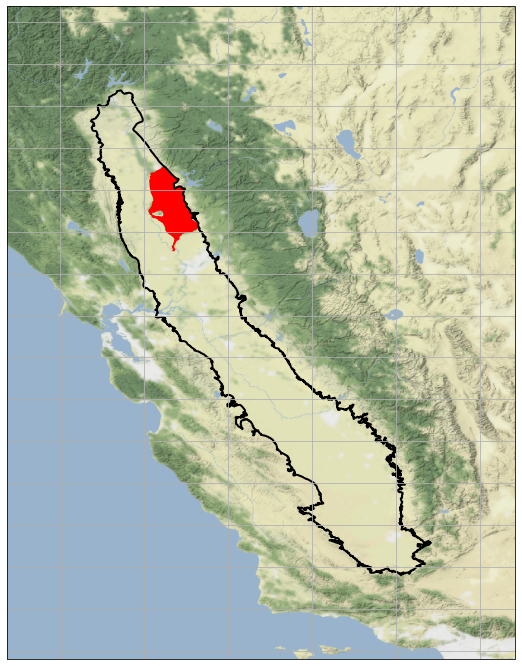

In [7]:
# Simple fig 
# Setup the figure
cv = ShapelyFeature(Reader("../shape/cv.shp").geometries(),
                        ccrs.PlateCarree(), edgecolor='black', facecolor = 'none', linewidth = 2)

shapefile = "../shape/cv.shp"
plt.figure(figsize = (16,12))
ax = plt.axes(projection=ccrs.PlateCarree())

# Get some 
imextent = gp.read_file(shapefile).to_crs(4326).bounds
crs= gp.read_file(shapefile).to_crs(4326)

lllon, lllat = imextent.minx.values[0], imextent.miny.values[0]
urlon, urlat = imextent.maxx.values[0], imextent.maxy.values[0]

# Create a Stamen Terrain instance.
stamen_terrain = cimgt.Stamen('terrain-background')

# Create a GeoAxes in the tile's projection.
gl = ax.gridlines(draw_labels=False)
gl.top_labels= False
gl.right_labels = False

gl.xlocator = mticker.FixedLocator(np.linspace(-180,180,361))
gl.ylocator = mticker.FixedLocator(np.linspace(0,90,181))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 9, 'color': 'gray'}
gl.ylabel_style = {'size': 9, 'color': 'gray'}

# Limit the extent of the map to a small longitude/latitude range.
ax.set_extent([lllon-1., urlon+1., lllat-1., urlat+1.])

# Add the Stamen data at zoom level 8.
ax.add_image(stamen_terrain, 8)
ax.add_feature(cv)
gp.read_file("../shape/butte/c2vsim_subregion5.shp").plot(facecolor = 'red', ax = ax)
# gp.read_file("../shape/kaweah/c2vsim_sub_18.shp").plot(facecolor = 'red', ax = ax)
# ax.set_axis_off()

In [8]:
# count wells in butte, kt

wells = gp.read_file("../shape/wells_in_cv.shp")

In [9]:
bsa = gp.read_file("../shape/butte/c2vsim_subregion5.shp")
ksa = gp.read_file("../shape/kaweah/c2vsim_sub_18.shp")

In [10]:
# gp.clip(wells, bsa).plot()
print(len(gp.clip(wells, ksa)))

2003


<ipython-input-10-f1b37cfeee4e>:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4236

  print(len(gp.clip(wells, ksa)))
